In [18]:
import pandas as pd
import numpy as np
from osprey.config import Config
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from os.path import join

In [19]:
frac_min, frac_max = 0.005, 1
fractions = [x for x in np.logspace(np.log10(frac_min), np.log10(frac_max), 5)]
result_dirs = ['data/{:05.1f}pc'.format(x*100) for x in fractions]

all_dfs = []
for i, result_dir in enumerate(result_dirs): 
    df = Config(join(result_dir, 'config.yaml')).trial_results()
    df['data_fraction'] = fractions[i]
    all_dfs.append(df)
    
df = pd.concat(all_dfs)
# i = 0
# result_dir = result_dirs[i]
# df = Config(join(result_dir, 'config.yaml')).trial_results()
# df['data_fraction'] = fractions[i]

Loading config file:     data/000.5pc/config.yaml...
Loading trials database: sqlite:///osprey-trials.db...
Loading config file:     data/001.9pc/config.yaml...
Loading trials database: sqlite:///osprey-trials.db...
Loading config file:     data/007.1pc/config.yaml...
Loading trials database: sqlite:///osprey-trials.db...
Loading config file:     data/026.6pc/config.yaml...
Loading trials database: sqlite:///osprey-trials.db...
Loading config file:     data/100.0pc/config.yaml...
Loading trials database: sqlite:///osprey-trials.db...


In [22]:
df = df.loc[df['project_name']=='default', :]

In [23]:
x = '000.5'
float(x)

0.5

In [24]:
df.head()
df.tail()
df.reset_index(inplace=True)
df.shape

(7502, 19)

In [25]:
df = df.loc[:, ['parameters', 'test_scores', 'train_scores', 'data_fraction']]

In [26]:
static_params = df.loc[0, 'parameters']
static_params

{'cluster__max': 1.2,
 'cluster__min': -1.2,
 'cluster__n_bins_per_feature': 10,
 'msm__connectivity': 'largest',
 'msm__count_mode': 'sliding',
 'msm__dt_traj': '1 step',
 'msm__lag': 25,
 'msm__maxerr': 1e-08,
 'msm__maxiter': 1000000,
 'msm__mincount_connectivity': '1/n',
 'msm__reversible': True,
 'msm__score_k': 2,
 'msm__score_method': 'vamp1',
 'msm__sparse': False,
 'msm__statdist_constraint': None}

In [27]:
variables = ['msm__score_k', 'msm__score_method', 'cluster__n_bins_per_feature']
for variable in variables: 
    df[variable] = df['parameters'].apply(lambda x: x[variable])
del df['parameters']

In [28]:
for x in ['test', 'train']:
    df[x+'_scores_std'] = df[x+'_scores'].apply(lambda x: np.std(x))
    df[x+'_scores_mean'] = df[x+'_scores'].apply(lambda x: np.mean(x))
    del df[x+'_scores']

In [29]:
df['t2_fraction'] = df['data_fraction'].apply(lambda x: '{:4.2f}'.format(x*10))
df['t2_fraction'].unique()

array(['0.05', '0.19', '0.71', '2.66', '10.00'], dtype=object)

In [30]:

df.rename(columns={'msm__score_k': 'k', 'msm__score_method': 'method','cluster__n_bins_per_feature': 'clusters'}, 
         inplace=True)
df.head()

,data_fraction,k,method,clusters,test_scores_std,test_scores_mean,train_scores_std,train_scores_mean,t2_fraction
0,0.005,2,vamp1,10,0.013982,1.973972,0.003402,1.975411,0.05
1,0.005,2,vamp2,10,0.027020,1.948818,0.006649,1.951438,0.05
2,0.005,2,vampe,10,0.029138,0.855020,0.006649,1.951438,0.05
3,0.005,3,vamp1,10,0.043417,2.759368,0.009944,2.774802,0.05
4,0.005,3,vamp2,10,0.072088,2.567230,0.016954,2.590518,0.05


In [31]:
df.to_pickle('data/all_results.pickl')

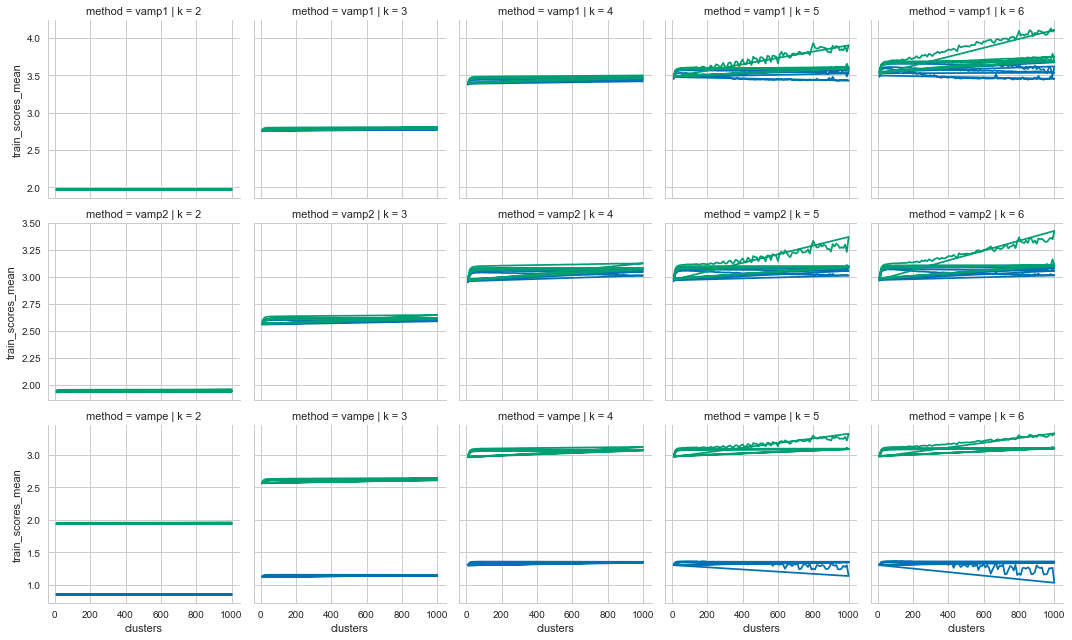

In [31]:
cols = sns.color_palette('colorblind')
g = sns.FacetGrid(data=df, row='method', col='k', sharey='row')
g.map(plt.plot, 'clusters', 'test_scores_mean', alpha=1, color=cols[0])
g.map(plt.plot, 'clusters', 'train_scores_mean', alpha=1, color=cols[1])

In [32]:
best_scores = df.groupby(['data_fraction',  'method', 'k'])['test_scores_mean'].max()
best_scores

data_fraction  method  k
0.005000       vamp1   2    1.976193
                       3    2.782325
                       4    3.441287
                       5    3.534588
                       6    3.596360
               vamp2   2    1.953108
                       3    2.604235
                       4    3.040340
                       5    3.056203
                       6    3.070228
               vampe   2    0.857014
                       3    1.155515
                       4    1.358767
                       5    1.362516
                       6    1.363447
0.018803       vamp1   2    1.974028
                       3    2.781636
                       4    3.453983
                       5    3.568794
                       6    3.613851
               vamp2   2    1.948783
                       3    2.601249
                       4    3.054040
                       5    3.067773
                       6    3.072065
               vampe   2    0.854592
             

In [33]:
best_idx = df.groupby(['data_fraction',  
                       'method', 'k'])['test_scores_mean'].transform(max) == df['test_scores_mean']

best_df = df.loc[best_idx, :].sort_values(by=['data_fraction',  'method', 'k'])
best_df.head()

,data_fraction,k,method,clusters,test_scores_std,test_scores_mean,train_scores_std,train_scores_mean,t2_fraction
120,0.005,2,vamp1,90,0.012441,1.976193,0.002991,1.978058,0.05
123,0.005,3,vamp1,90,0.039315,2.782325,0.008733,2.801752,0.05
126,0.005,4,vamp1,90,0.053023,3.441287,0.007342,3.483827,0.05
114,0.005,5,vamp1,80,0.086023,3.534588,0.013986,3.603929,0.05
57,0.005,6,vamp1,40,0.097176,3.596360,0.018720,3.684512,0.05


## k=4 only

In [34]:
methods = df['method'].unique()
t2_fracs = df['t2_fraction'].unique()


In [40]:
k = 4
df_sample = df.loc[df['k']==k, :]
best_df_sample = best_df.loc[df['k']==k, :]
cols = sns.color_palette('colorblind', 3)
print(cols)

[(0.0, 0.4470588235294118, 0.6980392156862745), (0.0, 0.6196078431372549, 0.45098039215686275), (0.8352941176470589, 0.3686274509803922, 0.0)]


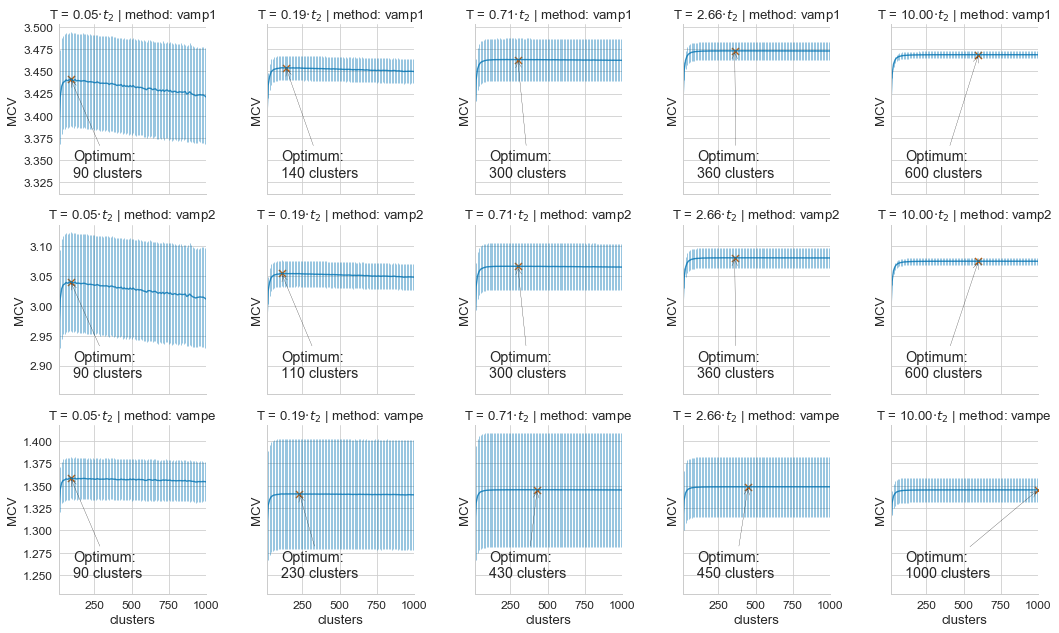

In [50]:
with sns.plotting_context('paper', font_scale=1.5):
    sns.set_style('whitegrid')
    g = sns.FacetGrid(data=df_sample,  col='t2_fraction', row='method', col_order=t2_fracs,
                      row_order=methods, sharey='row')
    g.map(plt.errorbar, 'clusters', 'test_scores_mean', 'test_scores_std', 
          alpha=0.8, color=cols[0], elinewidth=.5)
#     g.map(plt.errorbar, 'clusters', 'test_scores_mean', 
#           alpha=0.8, color=cols[0])
     
    g.set_titles('T = {col_name}$ \cdot t_2$ | method: {row_name}' )
    g.set(ylabel='MCV', xlim=(10,1000))
    for i in range(g.axes.shape[0]):
        for j in range(g.axes.shape[1]):
            ax = g.axes[i][j]
            idx = (best_df_sample['method']==methods[i]) & (best_df_sample['data_fraction']==fractions[j])
                
            x = best_df_sample.loc[idx, 'clusters']
            y = best_df_sample.loc[idx, 'test_scores_mean']
            ax.scatter(x, y, c=cols[-1], marker='x', s=50)
            
            label = 'Optimum:\n{} clusters'.format(x.values[0])
            ax.annotate(label,
                    xy=(x, y), xycoords='data',
                    xytext=(.1, .1),  textcoords='axes fraction', 
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3"),
                    )

    plt.savefig('figures/k4_with_errors.png', transparent=True)
# g.map(plt.errorbar, 'cluster__n_bins_per_feature', 'train_scores_mean','train_scores_std',  alpha=1, color=cols[1])

## m = 90 

In [37]:
m = 90
df_sample = df.loc[df['clusters']==m, :]
df_sample.loc[df_sample['method']=='vampe', :]

,data_fraction,k,method,clusters,test_scores_std,test_scores_mean,train_scores_std,train_scores_mean,t2_fraction
122,0.005000,2,vampe,90,0.030032,0.856910,0.005861,1.956606,0.05
125,0.005000,3,vampe,90,0.055866,1.155515,0.015229,2.635117,0.05
128,0.005000,4,vampe,90,0.022985,1.358767,0.013023,3.100367,0.05
131,0.005000,5,vampe,90,0.023877,1.362516,0.013591,3.115119,0.05
134,0.005000,6,vampe,90,0.024862,1.363319,0.014067,3.124458,0.05
1623,0.018803,2,vampe,90,0.027153,0.854536,0.003442,1.950440,0.19
1626,0.018803,3,vampe,90,0.082263,1.141962,0.007923,2.607044,0.19
1629,0.018803,4,vampe,90,0.061582,1.340358,0.005385,3.061353,0.19
1632,0.018803,5,vampe,90,0.061648,1.346718,0.005942,3.077076,0.19
1635,0.018803,6,vampe,90,0.062549,1.348069,0.006515,3.082705,0.19


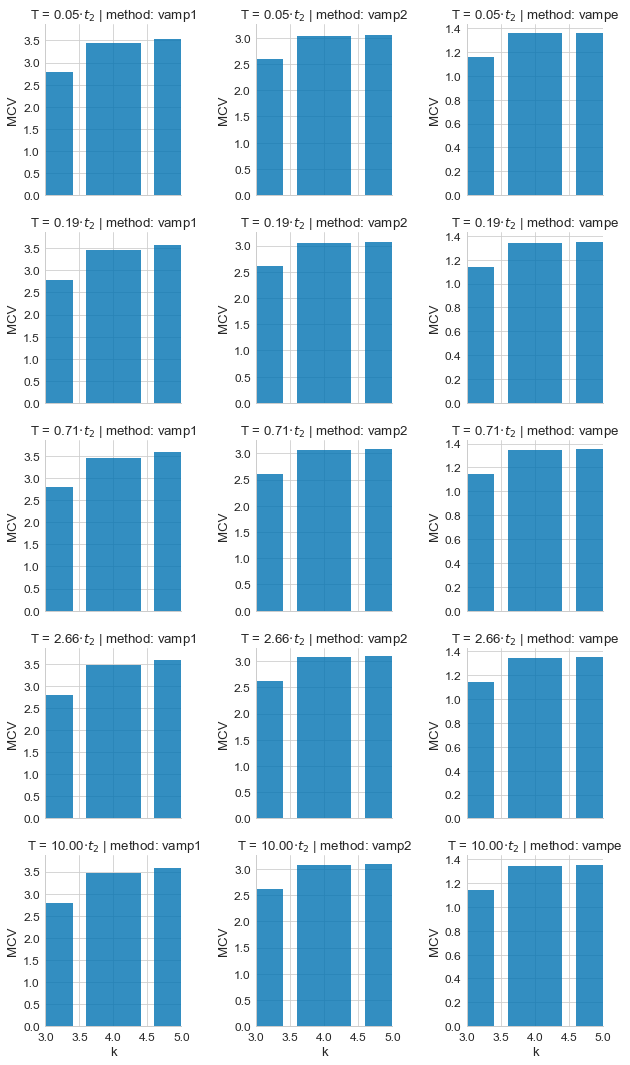

In [38]:
with sns.plotting_context('paper', font_scale=1.5):
    sns.set_style('whitegrid')
    g = sns.FacetGrid(data=df_sample,  row='t2_fraction', col='method', col_order=methods,
                      row_order=t2_fracs, sharey='col')
#     g.map(plt.errorbar, 'clusters', 'test_scores_mean', 'test_scores_std', 
#           alpha=0.8, color=cols[0], elinewidth=.5)
    g.map(plt.bar, 'k', 'test_scores_mean', 
          alpha=0.8, color=cols[0])
     
    g.set_titles('T = {row_name}$ \cdot t_2$ | method: {col_name}' )
    g.set(ylabel='MCV', xlim=(3,5))
#     for i in range(g.axes.shape[0]):
#         for j in range(g.axes.shape[1]):
#             ax = g.axes[i][j]
#             idx = (best_df_sample['method']==methods[j]) & (best_df_sample['data_fraction']==fractions[i])
                
#             x = best_df_sample.loc[idx, 'clusters']
#             y = best_df_sample.loc[idx, 'test_scores_mean']
#             ax.scatter(x, y, c=cols[-1], marker='x', s=50)
            
#             label = 'Optimum:\n{} clusters'.format(x.values[0])
#             ax.annotate(label,
#                     xy=(x, y), xycoords='data',
#                     xytext=(.1, .1),  textcoords='axes fraction', 
#                     arrowprops=dict(arrowstyle="->",
#                                     connectionstyle="arc3"),
#                     )

#     plt.savefig('m90.pdf')
# g.map(plt.errorbar, 'cluster__n_bins_per_feature', 'train_scores_mean','train_scores_std',  alpha=1, color=cols[1])

In [39]:
# best_df_sample = best_df.loc[df['m']==k, :]
